<a href="https://colab.research.google.com/github/OJB-Quantum/Notebooks-for-Ideas/blob/main/4_Micron_Josphson_Junction_with_GDSTK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authored by Onri Jay Benally (2025)

Open Access (CC-BY-4.0)

In [ ]:
# Colab: install geometry + I/O stack.
!pip -q install gdstk ezdxf shapely matplotlib numpy pylint

In [10]:
"""
Adjusted Colab script for a 4 µm-diameter conventional JJ + π-junction loop.
Key changes:
  • TARGET_PILLAR_DIAMETER_UM set to 4.0 µm.
  • New Jc knob (JC_UA_PER_UM2) — Ic computed from area, not a fixed guess.
  • Inductance target L recomputed from βL and computed Ic.
  • Reports EJ/h, EC/h, EJ/EC for quick regime checks.
"""

from __future__ import annotations

import math
from typing import List, Tuple

import numpy as np
import matplotlib.pyplot as plt
import gdstk
from shapely.geometry import Polygon as ShapelyPolygon

# Optional DXF support
try:
    import ezdxf
    EZDXF_OK = True
except Exception:
    EZDXF_OK = False

# ------------------------- Control knobs ------------------------- #
# Target pillar (conventional JJ) diameter — ADJUSTED to 4 µm.
TARGET_PILLAR_DIAMETER_UM: float = 4.0

# Pillar detection in your *input* mask (pre-scale): sub-0.3 µm near-circular.
PILLAR_CIRCULARITY_MIN: float = 0.20
PILLAR_CIRCULARITY_MAX: float = 1.20
PILLAR_MAX_DIAM_UM_FOR_DETECT: float = 0.30

# Critical-current density knob — Ic will be computed from Jc × (πr^2).
# Examples: 0.30 µA/µm² (30 A/cm²), 1.0 µA/µm² (100 A/cm²), 10 µA/µm² (1 kA/cm²)
JC_UA_PER_UM2: float = 1.0  # default 100 A/cm²

# Specific capacitance model knob.
# Option A (simple): set a fixed Cs.  Use ~50 fF/µm² as a typical tunnel-barrier value.
FIXED_CS_FF_PER_UM2: float | None = None  # e.g., 50.0 to force a constant value

# Option B (empirical): a tiny helper that returns Cs(Jc) ≈ {0.3→37, 1.0→50, 45→59} fF/µm² (piecewise).
# This is a coarse interpolation across common process nodes.
def estimate_cs_ff_per_um2(jc_uA_per_um2: float) -> float:
    points = [(0.3, 37.0), (1.0, 50.0), (45.0, 59.0)]
    # Clamp
    if jc_uA_per_um2 <= points[0][0]:
        return points[0][1]
    if jc_uA_per_um2 >= points[-1][0]:
        return points[-1][1]
    # Linear interpolate in log-jc (rough heuristic)
    x = np.log10(jc_uA_per_um2)
    xs = np.log10([p[0] for p in points])
    ys = np.array([p[1] for p in points], dtype=float)
    return float(np.interp(x, xs, ys))

# Flux-qubit loop goals.
TARGET_BETA_L: float = 1.8            # βL ≡ 2π L Ic / Φ0
WIRE_WIDTH_UM: float = 2.0            # loop linewidth
SHEET_LK_PH_PER_SQ: float = 3.0       # sheet kinetic inductance [pH/□]
EXTRA_GEO_INDUCTANCE_NH: float = 0.05 # slack for geometric inductance [nH]

# π-junction footprint (mask placeholder) — ADJUSTED to ~4 µm × 4 µm by default.
PI_MOD_WIDTH_UM: float = 4.0          # along current
PI_MOD_LENGTH_UM: float = 4.0         # across current
PI_CLEARANCE_UM: float = 1.5

# Layers (map to your PDK).
LAYER_WIRING: int = 1
LAYER_JJ_PILLAR: int = 10
LAYER_PI_MODULE: int = 20
LAYER_TRIM_COIL: int = 5
LAYER_LABELS: int = 90

# Output.
OUT_GDS: str = "singleJJ_pi_qubit_4umJJ.gds"
OUT_DXF: str = "singleJJ_pi_qubit_4umJJ.dxf"

# Physical constants and units.
PHI0_WB: float = 2.067833848e-15
E_CHARGE_C: float = 1.602176634e-19
PLANCK_J_S: float = 6.62607015e-34
UM_TO_M: float = 1e-6

plt.rcParams["figure.dpi"] = 200

In [11]:
def polygon_area_perimeter(points_um: np.ndarray) -> tuple[float, float]:
    """Return (area[µm²], perimeter[µm]) for a closed polygon in µm units."""
    poly = ShapelyPolygon(points_um)
    return float(poly.area), float(poly.length)

def circularity(area_um2: float, perim_um: float) -> float:
    """Return 4πA/P²; equals 1 for a perfect circle."""
    if perim_um <= 0:
        return 0.0
    return 4.0 * math.pi * area_um2 / (perim_um * perim_um)

def approx_diameter_from_area(area_um2: float) -> float:
    """Circle-equivalent diameter from area."""
    if area_um2 <= 0:
        return 0.0
    return 2.0 * math.sqrt(area_um2 / math.pi)

def circle_polygon(cx_um: float, cy_um: float, d_um: float, n: int = 96) -> np.ndarray:
    """Regular n-gon approximating a circle (for the JJ pillar opening)."""
    r = d_um / 2.0
    ang = np.linspace(0, 2 * np.pi, n, endpoint=False)
    return np.stack([cx_um + r * np.cos(ang), cy_um + r * np.sin(ang)], axis=1)

def plot_polygons(polys: list[np.ndarray], title: str = "Preview", alpha: float = 0.4) -> None:
    """Quick matplotlib preview of polygons."""
    fig, ax = plt.subplots(figsize=(7, 6))
    for p in polys:
        x, y = p[:, 0], p[:, 1]
        ax.fill(x, y, alpha=alpha)
    ax.set_aspect("equal")
    ax.set_title(title)
    ax.set_xlabel("µm")
    ax.set_ylabel("µm")
    ax.grid(True)
    plt.show()

In [12]:
from google.colab import files

def load_polygons_um(fname: str) -> tuple[list[np.ndarray], float]:
    """Load polygons from GDS or DXF; return (list of Nx2 µm-polys, file→µm scale)."""
    if fname.lower().endswith((".gds", ".gdsii")):
        lib = gdstk.read_gds(fname)
        unit_m = lib.unit  # meters per library user unit
        polys_um: list[np.ndarray] = []
        for cell in lib.top_level():
            flat = cell.flatten()
            for poly in flat.polygons:
                pts_um = np.array(poly.points, dtype=float) * (unit_m / UM_TO_M)
                polys_um.append(pts_um)
            for path in flat.paths:
                for pts in path.to_polygons():
                    pts_um = np.array(pts, dtype=float) * (unit_m / UM_TO_M)
                    polys_um.append(pts_um)
        return polys_um, (unit_m / UM_TO_M)

    if fname.lower().endswith(".dxf") and EZDXF_OK:
        doc = ezdxf.readfile(fname)
        msp = doc.modelspace()
        polys_um: list[np.ndarray] = []
        for e in msp.query("LWPOLYLINE"):
            pts = np.array([(p[0], p[1]) for p in e.get_points("xy")], dtype=float)
            if len(pts) >= 3:
                polys_um.append(pts)
        for e in msp.query("POLYLINE"):
            pts = np.array([(v.dxf.location.x, v.dxf.location.y) for v in e.vertices()], dtype=float)
            if len(pts) >= 3:
                polys_um.append(pts)
        return polys_um, 1.0

    raise RuntimeError("Unsupported format or ezdxf not installed.")

print("Upload your GDS or DXF now...")
up = files.upload()
assert up, "No file uploaded."
SRC_FILE = list(up.keys())[0]
polys_um_raw, file_to_um = load_polygons_um(SRC_FILE)
print(f"Loaded {len(polys_um_raw)} polygons. File→µm scale = {file_to_um:g}")

Upload your GDS or DXF now...


Saving 80nm_JJ_Qubit.gds to 80nm_JJ_Qubit (1).gds
Loaded 8 polygons. File→µm scale = 1


In [13]:
# Find small, near-circular candidates (pre-scale) -> expect ~80 nm in your file.
cand = []
for pts in polys_um_raw:
    area, perim = polygon_area_perimeter(pts)
    if area <= 0:
        continue
    circ = circularity(area, perim)
    diam = approx_diameter_from_area(area)
    if (PILLAR_CIRCULARITY_MIN <= circ <= PILLAR_CIRCULARITY_MAX) and (diam < PILLAR_MAX_DIAM_UM_FOR_DETECT):
        cand.append((pts, area, perim, circ, diam))

if not cand:
    print("WARNING: No near-circular sub-0.3 µm features detected; assuming 80 nm baseline.")
    detected_pillar_d_um = 0.08
else:
    cand_sorted = sorted(cand, key=lambda t: t[4])
    detected_pillar_d_um = float(np.median([t[4] for t in cand_sorted[: min(10, len(cand_sorted))]]))
    print(f"Detected pillar diameter (median pre-scale) ≈ {detected_pillar_d_um*1e3:.1f} nm")

# Scale factor to reach 4.0 µm pillar diameter.
scale_factor = TARGET_PILLAR_DIAMETER_UM / detected_pillar_d_um
print(f"Scale factor: {scale_factor:.3f}×  (to reach {TARGET_PILLAR_DIAMETER_UM:.2f} µm)")

Detected pillar diameter (median pre-scale) ≈ 79.1 nm
Scale factor: 50.580×  (to reach 4.00 µm)


In [14]:
# Conventional JJ area at the target diameter.
A_um2 = math.pi * (TARGET_PILLAR_DIAMETER_UM / 2.0) ** 2
Ic_uA = JC_UA_PER_UM2 * A_um2                          # µA
Ic_A = Ic_uA * 1e-6                                     # A

# Specific capacitance Cs
if FIXED_CS_FF_PER_UM2 is not None:
    Cs_fF_per_um2 = float(FIXED_CS_FF_PER_UM2)
else:
    Cs_fF_per_um2 = estimate_cs_ff_per_um2(JC_UA_PER_UM2)

Cj_fF = Cs_fF_per_um2 * A_um2                           # fF
Cj_F = Cj_fF * 1e-15

# Energies
EJ_over_h_GHz = (PHI0_WB / (2.0 * math.pi * PLANCK_J_S)) * Ic_A / 1e9
EC_over_h_GHz = (E_CHARGE_C * E_CHARGE_C / (2.0 * PLANCK_J_S)) / Cj_F / 1e9
ratio_EJ_EC = EJ_over_h_GHz / EC_over_h_GHz if EC_over_h_GHz > 0 else float("inf")

# Inductance target from βL and Ic
L_target_H = (TARGET_BETA_L * PHI0_WB) / (2.0 * math.pi * Ic_A)
L_target_nH = L_target_H * 1e9
L_needed_nH = max(L_target_nH - EXTRA_GEO_INDUCTANCE_NH, 0.0)

# Kinetic inductance budget: Lk ≈ Ls_per_sq * (length / width)
squares_needed = (L_needed_nH * 1e3) / max(SHEET_LK_PH_PER_SQ, 1e-9)  # nH→pH
meander_length_um = squares_needed * WIRE_WIDTH_UM

print("=== 4 µm JJ electrical summary ===")
print(f"Area A = {A_um2:.3f} µm²,  Jc = {JC_UA_PER_UM2:.3f} µA/µm²  →  Ic = {Ic_uA:.3f} µA")
print(f"Cs ≈ {Cs_fF_per_um2:.1f} fF/µm²  →  Cj ≈ {Cj_fF:.1f} fF")
print(f"EJ/h ≈ {EJ_over_h_GHz:,.1f} GHz,  EC/h ≈ {EC_over_h_GHz:,.3f} GHz,  EJ/EC ≈ {ratio_EJ_EC:,.0f}")
print(f"βL target = {TARGET_BETA_L:.2f}  →  L_target ≈ {L_target_nH:.3f} nH")
print(f"Kinetic-L needed ≈ {L_needed_nH:.3f} nH  →  squares ≈ {squares_needed:.1f},  meander length ≈ {meander_length_um:.1f} µm")

=== 4 µm JJ electrical summary ===
Area A = 12.566 µm²,  Jc = 1.000 µA/µm²  →  Ic = 12.566 µA
Cs ≈ 50.0 fF/µm²  →  Cj ≈ 628.3 fF
EJ/h ≈ 6,241.5 GHz,  EC/h ≈ 0.031 GHz,  EJ/EC ≈ 202,458
βL target = 1.80  →  L_target ≈ 0.047 nH
Kinetic-L needed ≈ 0.000 nH  →  squares ≈ 0.0,  meander length ≈ 0.0 µm


In [15]:
def scaled_polygons(polys: list[np.ndarray], s: float) -> list[np.ndarray]:
    """Uniform scale about origin."""
    return [p * s for p in polys]

def meander_polys(start_xy: tuple[float, float],
                  total_len_um: float,
                  width_um: float,
                  pitch_um: float,
                  n_turns: int,
                  layer: int) -> list[gdstk.Polygon]:
    """Rectangular meander to approximate a target length."""
    if total_len_um <= 0 or n_turns <= 0:
        return []
    polys = []
    x, y = start_xy
    seg_len = total_len_um / (n_turns * 2)
    for k in range(n_turns):
        # forward horizontal
        p0 = np.array([[x, y - width_um / 2], [x + seg_len, y - width_um / 2],
                       [x + seg_len, y + width_um / 2], [x, y + width_um / 2]])
        polys.append(gdstk.Polygon(p0, layer=layer))
        x = x + seg_len
        # vertical jog
        dir_sign = 1.0 if (k % 2 == 0) else -1.0
        p1 = np.array([[x - width_um / 2, y], [x + width_um / 2, y],
                       [x + width_um / 2, y + dir_sign * pitch_um],
                       [x - width_um / 2, y + dir_sign * pitch_um]])
        polys.append(gdstk.Polygon(p1, layer=layer))
        y = y + dir_sign * pitch_um
        # backward horizontal
        p2 = np.array([[x - seg_len, y - width_um / 2], [x, y - width_um / 2],
                       [x, y + width_um / 2], [x - seg_len, y + width_um / 2]])
        polys.append(gdstk.Polygon(p2, layer=layer))
        x = x - seg_len
    return polys

# 6a) Scale all incoming polygons.
scaled_polys_um = scaled_polygons(polys_um_raw, scale_factor)

# 6b) Identify two smallest circular pillars again after scaling to locate centers; remove old ones.
pillar_candidates_scaled = []
for pts in scaled_polys_um:
    area, perim = polygon_area_perimeter(pts)
    if area <= 0:
        continue
    circ = circularity(area, perim)
    diam = approx_diameter_from_area(area)
    if (PILLAR_CIRCULARITY_MIN <= circ <= PILLAR_CIRCULARITY_MAX) and (diam < TARGET_PILLAR_DIAMETER_UM * 1.5):
        pillar_candidates_scaled.append((pts, area, perim, circ, diam))

pillar_candidates_scaled = sorted(pillar_candidates_scaled, key=lambda t: t[4])
if len(pillar_candidates_scaled) >= 2:
    p0 = np.array(pillar_candidates_scaled[0][0])
    p1 = np.array(pillar_candidates_scaled[1][0])
    c0 = tuple(np.mean(p0, axis=0))  # conventional JJ center
    c1 = tuple(np.mean(p1, axis=0))  # π-module center
else:
    c0 = (0.0, 0.0)
    c1 = (10.0, 0.0)

print(f"Centers: JJ0 at {c0},  PI-module at {c1}  (µm)")

# Remove legacy small pillars from wiring copy.
scaled_polys_wiring = []
for pts in scaled_polys_um:
    area, perim = polygon_area_perimeter(pts)
    circ = circularity(area, perim)
    diam = approx_diameter_from_area(area)
    if (PILLAR_CIRCULARITY_MIN <= circ <= PILLAR_CIRCULARITY_MAX) and (diam < TARGET_PILLAR_DIAMETER_UM * 1.5):
        continue  # drop old pillars
    scaled_polys_wiring.append(pts)

# 6c) Create library/cell with µm user units.
lib = gdstk.Library(unit=UM_TO_M, precision=1e-9)
cell = lib.new_cell("SINGLEJJ_PI_QUBIT_4UM")

# Add scaled wiring.
for pts in scaled_polys_wiring:
    cell.add(gdstk.Polygon(pts, layer=LAYER_WIRING))

# 6d) New 4 µm JJ pillar at c0.
jj0_circle = circle_polygon(c0[0], c0[1], TARGET_PILLAR_DIAMETER_UM, n=128)
cell.add(gdstk.Polygon(jj0_circle, layer=LAYER_JJ_PILLAR))

# 6e) π-module footprint near c1 (rectangle).
x0 = c1[0] - PI_MOD_WIDTH_UM / 2.0
y0 = c1[1] - PI_MOD_LENGTH_UM / 2.0
x1 = c1[0] + PI_MOD_WIDTH_UM / 2.0
y1 = c1[1] + PI_MOD_LENGTH_UM / 2.0
pi_rect = np.array([[x0, y0], [x1, y0], [x1, y1], [x0, y1]])
cell.add(gdstk.Polygon(pi_rect, layer=LAYER_PI_MODULE))

# 6f) Meander to realize required kinetic-L (may be short if Ic is large and L_target small).
start_pt = (x1 + PI_CLEARANCE_UM + 5.0, y1 + 5.0)
n_turns = max(int(max(meander_length_um, 0.0) // 10.0), 1)
meander = meander_polys(start_pt, max(meander_length_um, 0.0),
                        WIRE_WIDTH_UM, pitch_um=3.0 * WIRE_WIDTH_UM,
                        n_turns=n_turns, layer=LAYER_WIRING)
for poly in meander:
    cell.add(poly)

# 6g) Tiny trim coil placeholder.
trim = gdstk.rectangle((c0[0] - 10, c0[1] - 10), (c0[0] - 3, c0[1] + 10), layer=LAYER_TRIM_COIL)
cell.add(trim)

# 6h) Labels (use 'origin' for gdstk.Label).
cell.add(gdstk.Label("JJ0 (4 µm pillar)", origin=c0, layer=LAYER_LABELS))
cell.add(gdstk.Label("PI_JJ module", origin=c1, layer=LAYER_LABELS))
cell.add(gdstk.Label(f"EJ/h≈{EJ_over_h_GHz:.1f}GHz, EC/h≈{EC_over_h_GHz:.3f}GHz, βL≈{TARGET_BETA_L:.2f}",
                     origin=(start_pt[0], start_pt[1] + 12.0), layer=LAYER_LABELS))

# Save GDS.
lib.write_gds(OUT_GDS)
print(f"Wrote {OUT_GDS}")

Centers: JJ0 at (np.float64(322935.1513805148), np.float64(373099.01108389936)),  PI-module at (np.float64(322985.73102272884), np.float64(373099.01108389936))  (µm)
Wrote singleJJ_pi_qubit_4umJJ.gds


In [16]:
if EZDXF_OK:
    doc = ezdxf.new(dxfversion="R2010")
    msp = doc.modelspace()
    for poly in cell.polygons:
        pts = [(float(p[0]), float(p[1])) for p in poly.points]
        if len(pts) >= 3:
            msp.add_lwpolyline(pts + [pts[0]], dxfattribs={"layer": f"L{poly.layer}"})
    doc.saveas(OUT_DXF)
    print(f"Wrote {OUT_DXF}")
else:
    print("DXF export skipped (ezdxf not installed).")

Wrote singleJJ_pi_qubit_4umJJ.dxf


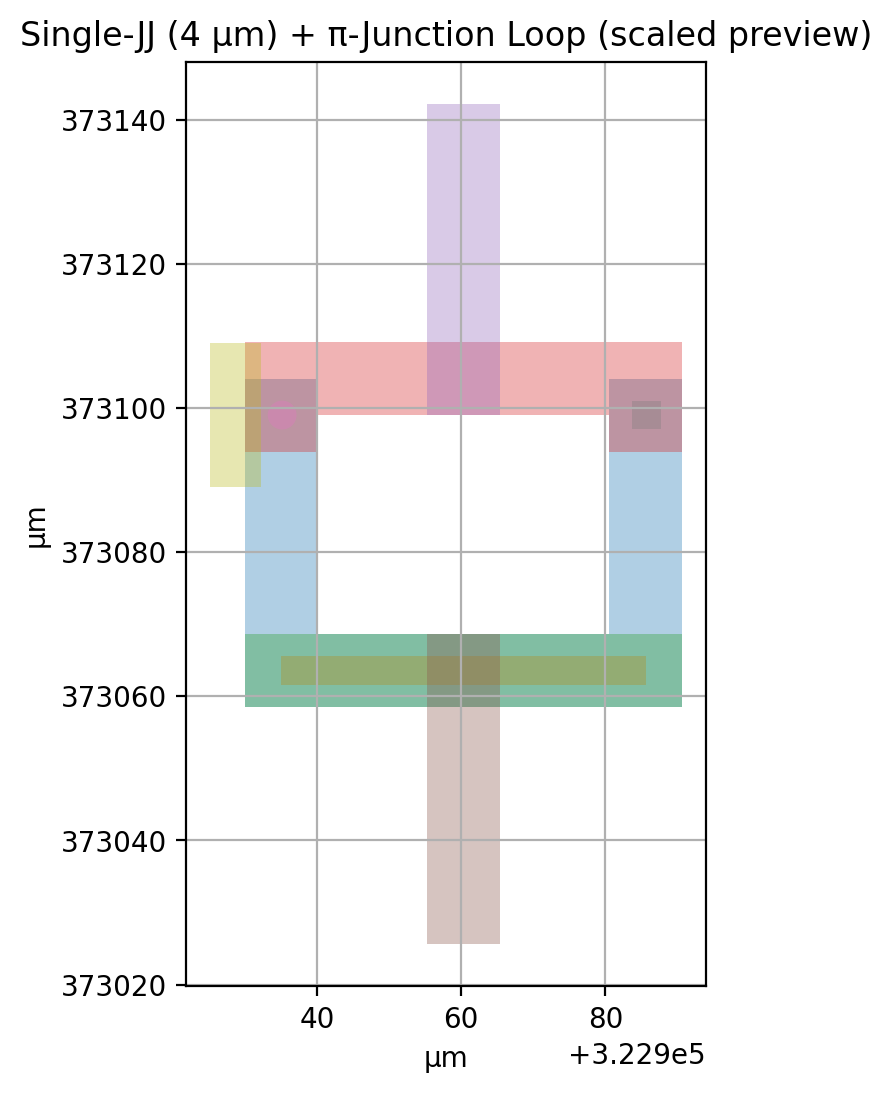

In [17]:
all_out = [np.array(poly.points, dtype=float) for poly in cell.polygons]
plot_polygons(all_out, title="Single-JJ (4 µm) + π-Junction Loop (scaled preview)", alpha=0.35)